In this notebook, I want to vertically coarse-grain cloud cover so that it yields a two-dimensional cloud fraction $C_a$. 

$C_a$ is more appropriate to calculate the radiative effect of clouds and the representation of precipitation. Clearly, $C_a$ is necessarily greater than or equal to the cloud cover $C_v$.

Eventually this needs to be a python-file that can be transferred to Piz Daint

*From Brooks et al. 2004:*

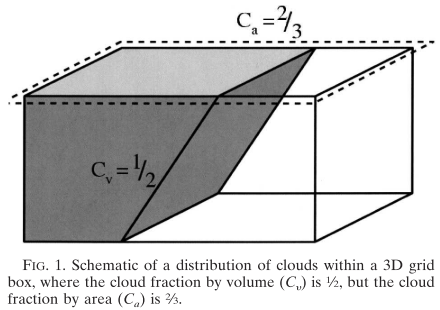

Step 1: Employ same cloud-overlap assumption as was used in the high-res model <br>
[Step 2: Horizontally coarse-grain using cdo remapcon (not here)]

Marco: Here either the maximum or the maximum-random overlap assumption could be used. 
Normally, if the sublevels simply resolve a portion of one cloud or the entire cloud, the maximum assumption would be used:
X(jc) = MAX(all jl)[x(jc,jl)]

**Maximum-random overlap:** <br>
Clouds in adjacent layers are maximally overlapped <br>
Groups of clouds separated by at least one layer are randomly overlapped <br>

In our case, one low res grid cell contains roughly three high res grid cells in the vertical. Therefore we can surely *use maximum overlap everywhere*.

**If one only wants to learn cloud area fraction, why doesn't it suffice to train on data that has not been vertically coarse-grained?** <br>
Given low-res data $\hat{X}$, we want to find a function f s.t. $f(\hat{X}) = \hat{C_a}$. Here, $\hat{C_a}$ is the best low-res estimate of the horizontal grid cell average of clouds. So we would expect that the (horizontal) cloud area fraction should be the same, independently of the cell height. Therefore one could argue that coarse-graining $C_a$ vertically is not required, if one wants to learn a function for cloud area fraction.

However, assume that $\hat{X}$ is some value, say 5. Now our NN has learned with the help of the high-res grid, that $X = 5$ always yields $C_a = 0.8$. 
However, let's say in the low-res grid, $\hat{X} = 5$ is usually the result of two high-res grid cells being contained in the low-res grid cell with $X = 10$ and $X = 0$ respectively. In that case, the best estimate of $C_a$ would be $max(f(10), f(0)) = 1$, but the NN would never expect $C_a = 1$ by looking at the high-res grid values only.

The catch is that in the low-res grid there is a much larger range of possibilities of how a certain value of $\hat{X}$ came about

In [ ]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
GRID_RES = 'R02B05'

# With NARVAL cloud cover

Run this code with 180GB

Want to interpolate (76, 4887488) -> (32, 4887488)

In [ ]:
# Define all paths
path = '/pf/b/b309170/scratch/orig_files'
base_path = '/pf/b/b309170/my_work/NARVAL'
dates = os.listdir(path)[1:]

# Which file to load
input_date = os.path.join(path, dates[1])
input_file = os.listdir(os.path.join(path, dates[1]))[0]
DS = xr.open_dataset(os.path.join(path, input_date, input_file))
print(input_file)

In [ ]:
# Load files (ds_zh_lr = ds_zhalf_lowres)
ds_zh_lr = xr.open_dataset(os.path.join(base_path, 'grid_extpar/zghalf_icon-a_capped_upsampled_R02B05.nc'))
ds_zh_hr = xr.open_dataset(os.path.join(base_path, 'grid_extpar/z_ifc_R02B10_NARVAL_fg_DOM01_ML.nc'))  

print(ds_zh_hr.z_ifc.values.shape)

# It's not entirely clear, whether this is the best grid to work with; see #116
print(ds_zh_lr.zghalf.values.shape)

In [ ]:
# Extract values
zh_lr = ds_zh_lr.zghalf.values
zh_hr = ds_zh_hr.z_ifc.values

HORIZ_FIELDS = zh_lr.shape[1]
VERT_LAYERS_LR = zh_lr.shape[0] - 1
VERT_LAYERS_HR = zh_hr.shape[0] - 1

clc = DS.clc.values
clc.shape

In [ ]:
# Pseuodocode:
# For every horizontal field i: <-- Maybe we can slice over the horizontal fields
# For every layer j:
# Set z_u=zh_lr[j, i] and z_l=zh_lr[j+1, i] <-- Define z_u and z_l, as encompassing layer j
# Collect all k with z_l <= zh_hr[k,i] <= z_u <-- Get all high-res half-level in between z_l and z_u
# These are exactly those layers, where weights > 0
# Then we have to loop over all horizontal fields, always taking the maximum high-res clc value of the overlapping fields

In [ ]:
# Have to run this code only once!
# Storing the weights in a file
weights = np.zeros((VERT_LAYERS_LR, VERT_LAYERS_HR, HORIZ_FIELDS))

for j in range(VERT_LAYERS_LR):
    z_u = zh_lr[j, :]
    z_l = zh_lr[j+1, :]
    weights_layer = np.maximum(np.minimum(z_u, zh_hr[:-1]) - np.maximum(zh_hr[1:], z_l), 0)

    weights[j, weights_layer > 0] = 1
    
np.save('weights_NARVAL_R02B10_area_fraction.npy', weights)

In [ ]:
# Requires 90GB, actually 160GB
weights = np.load('weights_NARVAL_R02B10_cloud_area_fraction.npy')
weights.shape

In [ ]:
clc[0].shape

In [ ]:
# Code takes 71 seconds per file (2.29s per vertical layer) on a prepost node

# Modify the ndarray. Desired output shape: (1, 31, 4887488). (clc_out = clc, vertically interpolated)
clc_out = np.full((1, 31, 4887488), np.nan)

for j in range(5):
    # Equivalent to the next line but 30 times slower:
    #  for m in range(HORIZ_FIELDS):
    #      clc_out[0, j, m] = np.max(clc[0, np.where(weights[:, m] > 0), m])
    
    clc_out[0][j] = np.max(weights[j]*clc[0], axis=0) #Element-wise product

In [ ]:
clc_new_da = xr.DataArray(clc_out, coords={'time':DS.time, 'height':DS.height[:31]}, 
                          dims=['time', 'height', 'cells'], name='clc') 

# Save it in a new file
output_file = 'int_var_' + input_file
clc_new_da.to_netcdf(output_file)

### TESTING
As a first test I compared the means, max/means with the linearly interpolated data to see if they are close. <br>
As a second test I compare the vertically interpolated cloud cover for an arbitrary data point:

In [ ]:
input_file = xr.open_dataset('clc_dei4_NARVALI_2013122600_cloud_DOM01_ML_0023.nc')
output_file = xr.open_dataset('int_var_clc_dei4_NARVALI_2013122600_cloud_DOM01_ML_0023.nc')

input_clc = input_file.clc.values
output_clc = output_file.clc.values

input_clc_mean = np.mean(input_clc[0], axis=1)
output_clc_mean = np.mean(output_clc[0], axis=1)

input_clc_max = np.max(input_clc[0], axis=1)
output_clc_max = np.max(output_clc[0], axis=1)

In [ ]:
fig = plt.figure(figsize=(11,3))

ax_1 = fig.add_subplot(121)
ax_1.plot(input_clc_mean, np.arange(len(input_clc_mean)))

ax_2 = fig.add_subplot(122)
ax_2.plot(output_clc_mean, np.arange(len(output_clc_mean)))

In [ ]:
fig = plt.figure(figsize=(11,3))

ax_1 = fig.add_subplot(121)
ax_1.plot(input_clc_max, np.arange(len(input_clc_max)))

ax_2 = fig.add_subplot(122)
ax_2.plot(output_clc_max, np.arange(len(output_clc_max)))

In [ ]:
m = 3000000

fig = plt.figure(figsize=(11,3))

ax_1 = fig.add_subplot(121)
ax_1.plot(input_clc[0][:, m], np.arange(len(input_clc_max)))

ax_2 = fig.add_subplot(122)
ax_2.plot(output_clc[0][:, m], np.arange(len(output_clc_max)))

In [ ]:
# Arbitrary data point
k = 20
l = 2071456

z_u = zh_lr[k, l] #3647.9666
z_l = zh_lr[k+1, l] #3069.0796
np.where(zh_hr[:, l] <= z_u) #51 and above
np.where(zh_hr[:, l] >= z_l) #52 and below
# clc[0, 50, l] #83.6644
# clc[0, 51, l] #78.92006
# clc[0, 52, l] #74.58538

In [ ]:
clc_out[0,k,l] == np.max([clc[0, 50, l], clc[0, 51, l], clc[0, 52, l]])